In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install compatible versions of TensorFlow and Protobuf
!pip install -U "tensorflow[and-cuda]" "protobuf<4.21.0"

INFO: pip is looking at multiple versions of tensorflow[and-cuda] to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 98.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 115.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
  Attempting uninstall: nvidia-nccl-cu12
    Found existing installation: nvidia-nccl-cu12 2.21.5
    Uninstalling nvidia-nccl-cu12-2.21.5:
      Successfully uninstalled nvidia-nccl-cu12-2.21.5
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Un

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

2025-11-28 11:07:34.506127: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764328054.526423      20 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764328054.532801      20 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764328054.549107      20 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764328054.549125      20 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764328054.549127      20 computation_placer.cc:177] computation placer alr

In [ ]:
# Constants
TRAIN_DIR = '/content/drive/MyDrive/moods/mood_dataset/train'
TEST_DIR = '/content/drive/MyDrive/moods/mood_dataset/test' # Kaggle often names validation 'test' in this dataset version

IMAGE_WIDTH = 48
IMAGE_HEIGHT = 48
IMAGE_DEPTH = 1
BATCH_SIZE = 32
EPOCHS = 60

In [ ]:
# Define Data Generators
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

print("Loading Training Data...")
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

print("Loading Test/Validation Data...")
validation_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # Important for classification report later
)

# Automatically detect labels and number of classes
CLASS_NAMES = list(train_generator.class_indices.keys())
NUM_CLASSES = train_generator.num_classes
print(f"Detected {NUM_CLASSES} classes: {CLASS_NAMES}")

Loading Training Data...
Found 28709 images belonging to 7 classes.
Loading Test/Validation Data...
Found 7178 images belonging to 7 classes.
Detected 7 classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [ ]:
def build_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_DEPTH)),

        # Block 1
        tf.keras.layers.Conv2D(64, (5, 5), activation='elu', padding='same', kernel_initializer='he_normal'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (5, 5), activation='elu', padding='same', kernel_initializer='he_normal'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3),

        # Block 2
        tf.keras.layers.Conv2D(128, (3, 3), activation='elu', padding='same', kernel_initializer='he_normal'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), activation='elu', padding='same', kernel_initializer='he_normal'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.4),

        # Block 3
        tf.keras.layers.Conv2D(256, (3, 3), activation='elu', padding='same', kernel_initializer='he_normal'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(256, (3, 3), activation='elu', padding='same', kernel_initializer='he_normal'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.5),

        # Block 4
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='elu', kernel_initializer='he_normal'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.6),

        # Dynamic output layer based on detected classes
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_model()
model.summary()

I0000 00:00:1764328077.852764      20 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,395,591 (9.14 MB)

 Trainable params: 2,393,543 (9.13 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [ ]:
# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00008,
    patience=12,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.5,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

# Start Training
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, lr_scheduler]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60


I0000 00:00:1764328086.131548      87 service.cc:152] XLA service 0x78fd700086b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764328086.131585      87 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1764328086.852819      87 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/897 ━━━━━━━━━━━━━━━━━━━━ 1:10 79ms/step - accuracy: 0.0972 - loss: 3.6458  

I0000 00:00:1764328093.971330      87 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


897/897 ━━━━━━━━━━━━━━━━━━━━ 166s 169ms/step - accuracy: 0.1956 - loss: 2.4716 - val_accuracy: 0.3227 - val_loss: 1.6816 - learning_rate: 0.0010
Epoch 2/60
  1/897 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.2500 - loss: 1.8064

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


897/897 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.2500 - loss: 1.8064 - val_accuracy: 0.3262 - val_loss: 1.6792 - learning_rate: 0.0010
Epoch 3/60
897/897 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.2971 - loss: 1.7480 - val_accuracy: 0.4135 - val_loss: 1.5135 - learning_rate: 0.0010
Epoch 4/60
897/897 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5312 - loss: 1.4847 - val_accuracy: 0.4160 - val_loss: 1.5099 - learning_rate: 0.0010
Epoch 5/60
897/897 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.3896 - loss: 1.5585 - val_accuracy: 0.4657 - val_loss: 1.3803 - learning_rate: 0.0010
Epoch 6/60
897/897 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5000 - loss: 1.2212 - val_accuracy: 0.4625 - val_loss: 1.3877 - learning_rate: 0.0010
Epoch 7/60
897/897 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.4477 - loss: 1.4283 - val_accuracy: 0.5066 - val_loss: 1.2956 - learning_rate: 0.0010
Epoch 8/60
897/897 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5312 - loss: 1.2640 - val_a

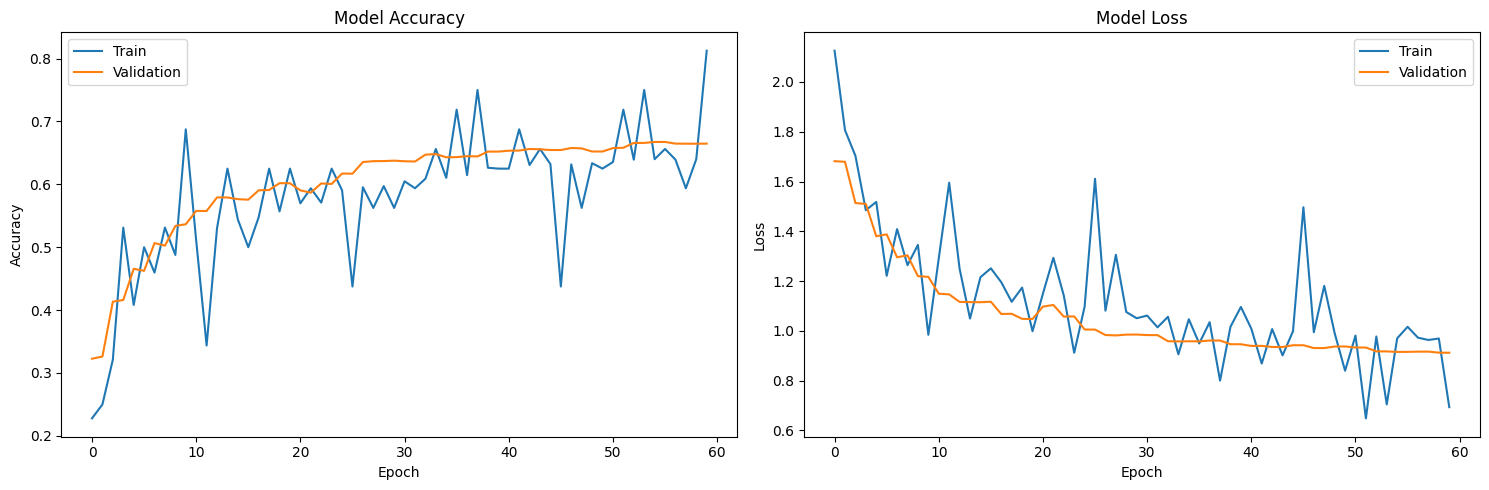

In [ ]:
def visualize_train_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy
    axes[0].plot(history.history['accuracy'], label='Train')
    axes[0].plot(history.history['val_accuracy'], label='Validation')
    axes[0].set_title('Model Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend()

    # Loss
    axes[1].plot(history.history['loss'], label='Train')
    axes[1].plot(history.history['val_loss'], label='Validation')
    axes[1].set_title('Model Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

visualize_train_history(history)

Evaluating on Validation Set...
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.6185 - loss: 1.0248
Validation Accuracy: 66.79%
Generating predictions...
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step

Classification Report:

              precision    recall  f1-score   support

       angry       0.60      0.62      0.61       958
     disgust       0.57      0.30      0.39       111
        fear       0.56      0.36      0.44      1024
       happy       0.86      0.88      0.87      1774
     neutral       0.57      0.73      0.64      1233
         sad       0.56      0.53      0.54      1247
    surprise       0.75      0.81      0.78       831

    accuracy                           0.67      7178
   macro avg       0.64      0.60      0.61      7178
weighted avg       0.66      0.67      0.66      7178



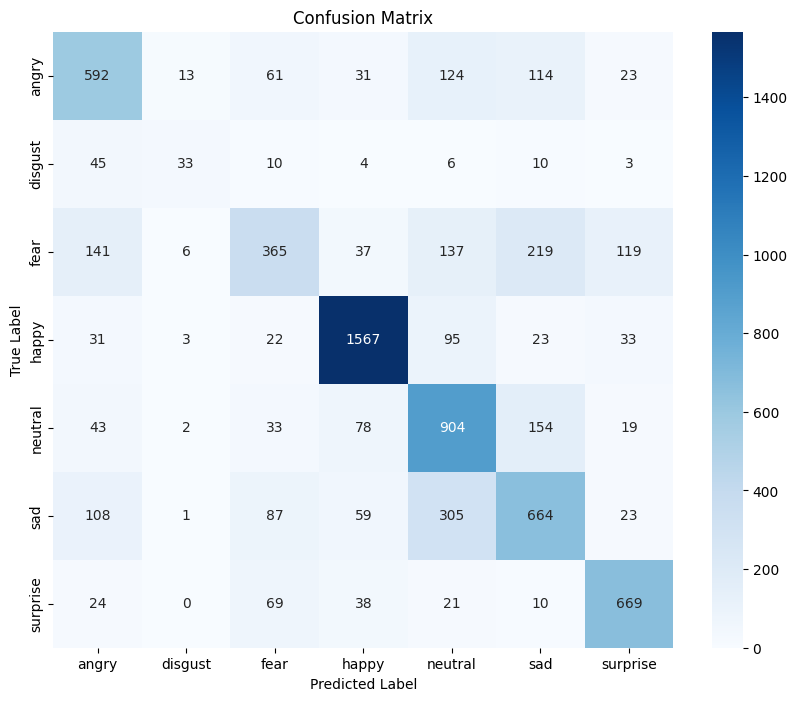

In [ ]:
def report_results():
    print("Evaluating on Validation Set...")
    # Evaluate returns [loss, accuracy]
    loss, accuracy = model.evaluate(validation_generator)
    print(f"Validation Accuracy: {accuracy*100:.2f}%")

    # Reset generator to start of loop to ensure order matches
    validation_generator.reset()

    # Make predictions
    print("Generating predictions...")
    predictions = model.predict(validation_generator, verbose=1)

    # Convert predictions to class indexes
    y_pred_indices = np.argmax(predictions, axis=1)

    # Get true labels directly from the generator
    y_true_indices = validation_generator.classes

    # Get the class names (labels)
    class_labels = list(validation_generator.class_indices.keys())

    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(y_true_indices, y_pred_indices, target_names=class_labels))

    # Confusion Matrix
    cm = confusion_matrix(y_true_indices, y_pred_indices)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

report_results()

In [ ]:
model.save('fer2013_model.h5')
print("Model saved successfully.")

Model saved successfully.


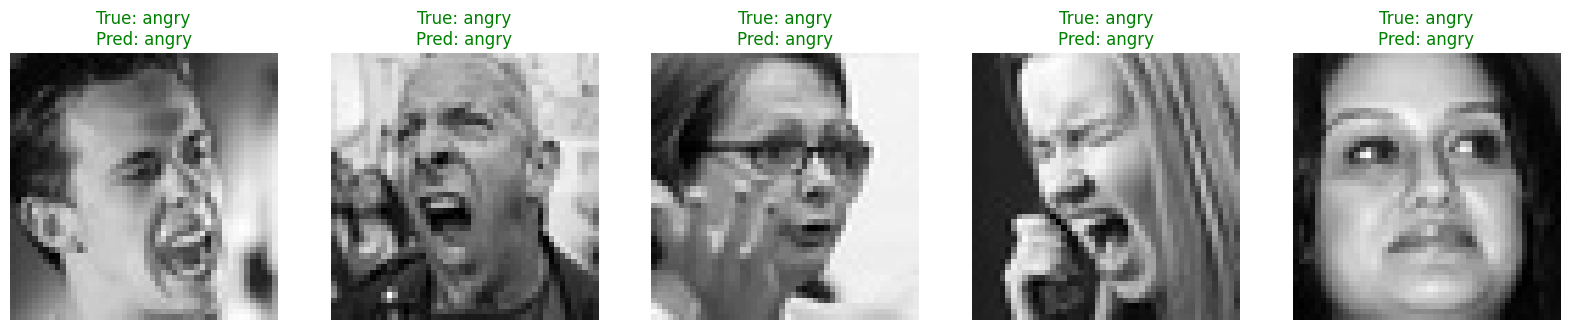

In [ ]:
def predict_random_samples():
    # Grab a single batch of images
    # We use next() to fetch the first batch from the generator
    images, labels = next(validation_generator)

    # Pick 5 random indices from this batch (batch size is usually 32)
    indices = np.random.choice(len(images), 5, replace=False)

    # Get class names map {0: 'angry', 1: 'happy', ...}
    class_map = {v: k for k, v in validation_generator.class_indices.items()}

    fig, axes = plt.subplots(1, 5, figsize=(20, 4))

    for i, idx in enumerate(indices):
        img = images[idx]

        # Get True Label
        true_idx = np.argmax(labels[idx])
        true_label = class_map[true_idx]

        # Get Prediction
        # Add extra dim because model expects (Batch, Height, Width, Channel)
        pred_prob = model.predict(np.expand_dims(img, axis=0), verbose=0)
        pred_idx = np.argmax(pred_prob)
        pred_label = class_map[pred_idx]

        # Display Image
        # Squeeze removes the channel dim (48,48,1) -> (48,48) for plotting
        axes[i].imshow(img.squeeze(), cmap='gray')
        axes[i].axis('off')

        # Title color: Green if correct, Red if wrong
        color = 'green' if true_label == pred_label else 'red'
        axes[i].set_title(f"True: {true_label}\nPred: {pred_label}", color=color)

    plt.show()

predict_random_samples()

In [ ]:
from tensorflow.keras.models import load_model

model_path = "/content/drive/MyDrive/moods/mood_dataset/model.h5"
model = load_model(model_path)

print("Model loaded successfully!")


Model loaded successfully!


In [ ]:
import numpy as np
import cv2
import pandas as pd
from tensorflow.keras.preprocessing.image import img_to_array

class_map = {
    0: 'angry',
    1: 'disgust',
    2: 'fear',
    3: 'happy',
    4: 'neutral',
    5: 'sad',
    6: 'surprise'
}

def predict_image(img_path, model):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (48, 48))
    img = img.astype("float") / 255.0

    img = img.reshape(48, 48, 1)
    img = np.expand_dims(img, axis=0)

    pred = model.predict(img, verbose=0)

    pred_idx = np.argmax(pred)
    pred_prob = np.max(pred)
    pred_label = class_map[pred_idx]

    return pred_label, float(pred_prob)

def load_song_dataset(csv_path):
    df = pd.read_csv(csv_path)
    return df

def get_teenage_year_range(current_year, age):

    teenage_offset = age - 25
    teenage_year = current_year - teenage_offset
    start_year = teenage_year - 5
    end_year = teenage_year + 5

    return start_year, end_year

def get_song_recommendations(df, mood, start_year, end_year):
    results = df[
        (df['mood'].str.lower() == mood.lower()) &
        (df['year'].between(start_year, end_year))
    ]

    return results


def recommend_songs_from_image(img_path, model, csv_path, age, current_year=2025):

    predicted_mood, confidence = predict_image(img_path, model)
    print(f"Detected Mood: {predicted_mood} (Confidence: {confidence:.2f})")
    df = load_song_dataset(csv_path)

    start_year, end_year = get_teenage_year_range(current_year, age)
    print(f"Teenage Range: {start_year} - {end_year}")
    recommendations = get_song_recommendations(df, predicted_mood, start_year, end_year)

    return recommendations


In [ ]:
from google.colab import files
import pandas as pd


csv_path = '/content/drive/MyDrive/moods/mood_dataset/songs.csv'


song_df = pd.read_csv(csv_path)

print("Upload your image(s) for emotion detection:")
uploaded_images = files.upload()


age = 60
current_year = 2025  # Can dynamically use datetime if needed

def get_teenage_year_range(current_year, age):
    teenage_offset = age - 25
    teenage_year = current_year - teenage_offset
    start_year = teenage_year - 5
    end_year = teenage_year + 5
    return start_year, end_year

def get_song_recommendations(df, mood, start_year, end_year):
    results = df[
        (df['mood'].str.lower() == mood.lower()) &
        (df['year'].between(start_year, end_year))
    ]
    return results

for img_name in uploaded_images.keys():
    print("\nProcessing Image:", img_name)


    pred_label, pred_prob = predict_image(img_name, model)  # model should be loaded
    print(f"Predicted Emotion: {pred_label} (Confidence: {pred_prob:.2f})")


    start_year, end_year = get_teenage_year_range(current_year, age)
    print(f"Teenage Year Range: {start_year}-{end_year}")

    # Filter songs
    recommended_songs = get_song_recommendations(song_df, pred_label, start_year, end_year)

    if not recommended_songs.empty:
        print("Recommended Songs:")
        print(recommended_songs)
    else:
        print("No songs found for this mood in your teenage years.")



Upload your image(s) for emotion detection:


Saving download (12).jpg to download (12).jpg

Processing Image: download (12).jpg
Predicted Emotion: angry (Confidence: 0.37)
Teenage Year Range: 1985-1995
Recommended Songs:
                song_name   mood  year
11           Nethu Salana  angry  1991
54     Handana Podi Puthu  angry  1985
56     Api Ayeth Dawasaka  angry  1993
57  Eka Yamaka Eka Reyaka  angry  1989
58             Sudu Sande  angry  1990
64         Nil Ahas Thale  angry  1991
65     Nidi Nathi Ra Yame  angry  1995


In [ ]:
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import img_to_array

# Class label mapping
class_map = {
    0: 'angry',
    1: 'disgust',
    2: 'fear',
    3: 'happy',
    4: 'neutral',
    5: 'sad',
    6: 'surprise'
}

def predict_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (48, 48))
    img = img.astype("float") / 255.0

    img = img.reshape(48, 48, 1)
    img = np.expand_dims(img, axis=0)

    pred = model.predict(img, verbose=0)

    pred_idx = np.argmax(pred)      # class index
    pred_prob = np.max(pred)        # confidence
    pred_label = class_map[pred_idx]  # mapped label

    return pred_idx, pred_label, pred_prob



In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

val_path = "/content/drive/MyDrive/moods/mood_dataset/test"   # <<< CHANGE THIS

datagen = ImageDataGenerator(rescale=1./255)

validation_generator = datagen.flow_from_directory(
    val_path,
    target_size=(48, 48),
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False
)


Found 7178 images belonging to 7 classes.


In [ ]:
class_map = {v: k for k, v in validation_generator.class_indices.items()}
print(class_map)


{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}
